<a href="https://colab.research.google.com/github/Luanmantegazine/FedAlzheimer/blob/main/FED_Alzheimer_ipynb_(FedProx)_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import torch
import time
import random
import os
import math
import copy
import torchmetrics
import numpy as np
import matplotlib as plt
from torch import nn
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import WeightedRandomSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score

#Definindo o número de clientes

In [ ]:
num_users = 7
num_classes =  3
epochs = 80
frac = 1
lr= 0.0001
batch_size = 32
criterion = nn.CrossEntropyLoss()
mu = 0.1

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tesla T4


#Importando o dataset

In [ ]:
data_path='/content/drive/MyDrive/TCC - Grupo SLD/Projeto 2/ADNI'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_path)

all_indices= list(range(len(full_dataset)))
np.random.shuffle(all_indices)


train_size = int(0.8 * len(full_dataset))
train_indices = all_indices[:train_size]
test_indices = all_indices[train_size:]


train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

train_dataset = CustomDataset(train_dataset, transform=train_transform)
test_dataset = CustomDataset(test_dataset, transform=test_transform)

labels_train = [y for _, y in train_dataset]
unique, counts = np.unique(labels_train, return_counts=True)
freq = dict(zip(unique, counts))
sample_weights = [1.0 / freq[y] for y in labels_train]

sampler_train = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler_train)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    return class_counts

train_class_counts = count_samples_per_class(train_dataset)
print("Initial class distribution in training set:", train_class_counts)


max_count = max(train_class_counts.values())


class_to_indices = {class_idx: [] for class_idx in range(num_classes)}
for idx, (_, label) in enumerate(train_dataset):
    class_to_indices[label].append(idx)

oversampled_indices = []
for class_idx, indices in class_to_indices.items():

    num_to_add = max_count - len(indices)
    if num_to_add > 0:
        indices_to_add = np.random.choice(indices, size=num_to_add, replace=True)
        oversampled_indices.extend(indices)
        oversampled_indices.extend(indices_to_add)
    else:
        oversampled_indices.extend(indices)

print(f"Total samples after oversampling: {len(oversampled_indices)}")

from torch.utils.data import Subset

oversampled_train_dataset = Subset(train_dataset, oversampled_indices)

train_loader = DataLoader(oversampled_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Initial class distribution in training set: Counter({2: 212, 1: 147, 0: 77})
Total samples after oversampling: 636


In [ ]:
def get_class_distribution(loader):
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.numpy())
    return class_counts

new_train_class_counts = get_class_distribution(train_loader)
print("New class distribution in training loader:", new_train_class_counts)


New class distribution in training loader: Counter({np.int64(0): 212, np.int64(1): 212, np.int64(2): 212})


#Definindo o treinamento dos clientes

In [ ]:
class ResNet50_Client(nn.Module):
    def __init__(self):
        super().__init__()
        # compatível com versões novas/antigas do torchvision
        try:
            resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        except Exception:
            resnet = models.resnet50(pretrained=True)

        # stem + layer1 + layer2 (saída 28x28 p/ input 224x224)
        self.stem = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

#Definindo o treinamento do servidor

In [ ]:
class ResNet50_Server(nn.Module):
    def __init__(self, num_classes=3, dropout_p=0.3):
        super().__init__()
        try:
            resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        except Exception:
            resnet = models.resnet50(pretrained=True)

        # continua a partir de layer3
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.pool   = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_p)
        self.classifier = nn.Linear(2048, num_classes)  # ResNet50 => 2048

    def forward(self, x):
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# Instanciando o modelo do lado do cliente
net_glob_client = ResNet50_Client()
if torch.cuda.device_count() > 1:
    print("Utilizando", torch.cuda.device_count(), "GPUs")
    net_glob_client = nn.DataParallel(net_glob_client)

net_glob_client.to(device)
print(net_glob_client)

# Instanciando o modelo do lado do servidor
net_glob_server = ResNet50_Server(num_classes=num_classes)
if torch.cuda.device_count() > 1:
    print("Utilizando", torch.cuda.device_count(), "GPUs")
    net_glob_server = nn.DataParallel(net_glob_server)

net_glob_server.to(device)
print(net_glob_server)

ResNet50_Client(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ker

In [ ]:
loss_train_collect = []
acc_train_collect = []
loss_test_collect = []
acc_test_collect = []
auc_train_collect = []
auc_test_collect = []
batch_acc_train = []
batch_loss_train = []
batch_precision_train = []
batch_recall_train = []
acc_train_collect_user = []
loss_train_collect_user = []
loss_test_collect_user = []
precision_train_collect_user = []
precision_test_collect = []
precision_train_collect = []
recall_test_collect = []
recall_train_collect_user = []
auc_train_collect_user = []
recall_train_collect = []
f1_test_collect = []
batch_auc_train = []
batch_acc_test = []
batch_loss_test = []
batch_prec_test = []
batch_recall_test = []
precision_avg_all_user_train = []
precision_test_collect_user = []
recall_test_collect_user = []
auc_test_collect_user = []
f1_test_collect_user = []
acc_test_collect_user = []


count1 = 0
count2 = 0

In [ ]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

def calculate_metrics(fx, y, num_classes):
    preds = fx.argmax(dim=1)
    accuracy = torchmetrics.functional.accuracy(preds, y, task='multiclass', num_classes=num_classes)
    precision = torchmetrics.functional.precision(preds, y, average='macro', task='multiclass', num_classes=num_classes)
    recall = torchmetrics.functional.recall(preds, y, average='macro', task='multiclass', num_classes=num_classes)
    f1 = torchmetrics.functional.f1_score(preds, y, average='macro', task='multiclass', num_classes=num_classes)
    auc = torchmetrics.functional.auroc(F.softmax(fx, dim=1), y, task='multiclass', num_classes=num_classes)
    return accuracy, precision, recall, f1, auc

w_glob_server = net_glob_server.state_dict()
w_locals_server = []
weight_decay = 1e-4


idx_collect = []
l_epoch_check = False
fed_check = False

net_model_server = [copy.deepcopy(net_glob_server)
                    for _ in range(num_users)]

net_server = copy.deepcopy(net_model_server[0]).to(device)
optimizer_server = torch.optim.Adam(net_server.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_server = torch.optim.lr_scheduler.StepLR(optimizer_server, step_size=30, gamma=0.1)


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, save_path='checkpoint.pt'):
        """
        Args:
            patience (int): How many epochs to wait after last validation loss improvement.
            verbose (bool): If True, prints messages about validation loss improvement.
            delta (float): Minimum change in monitored quantity to qualify as improvement.
            save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.save_path = save_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf  # Initialize with infinity

    def __call__(self, val_loss, models):
        net_glob_client, net_glob_server = models
        score = -val_loss  # Because lower validation loss is better

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, net_glob_client, net_glob_server)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, net_glob_client, net_glob_server)
            self.counter = 0

    def save_checkpoint(self, val_loss, net_glob_client, net_glob_server):
        '''Saves models when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving models...')
        torch.save({
            'net_glob_client_state_dict': net_glob_client.state_dict(),
            'net_glob_server_state_dict': net_glob_server.state_dict(),
        }, self.save_path)
        self.val_loss_min = val_loss


In [ ]:
def train_server(fx_client, y, l_epoch_count, l_epoch, idx, len_batch, num_classes=3):
    global net_model_server, criterion, optimizer_server, device
    global batch_acc_train, batch_loss_train, batch_precision_train, batch_recall_train, batch_auc_train
    global l_epoch_check, fed_check, loss_train_collect, acc_train_collect, count1
    global acc_avg_all_user_train, loss_avg_all_user_train, idx_collect, w_locals_server, w_glob_server, net_server
    global loss_train_collect_user, acc_train_collect_user, precision_train_collect_user, recall_train_collect_user, auc_train_collect_user  # Add these variables
    global precision_train_collect, recall_train_collect, auc_train_collect
    global lr

    net_server = net_model_server[idx].to(device)
    net_server.train()
    optimizer_server = torch.optim.Adam(net_server.parameters(), lr=lr, weight_decay=weight_decay)

    optimizer_server.zero_grad()
    fx_client = fx_client.to(device)
    y = y.to(device)

    fx_server = net_server(fx_client)
    loss = criterion(fx_server, y)
    acc, precision, recall, f1, auc = calculate_metrics(fx_server, y, num_classes)

    loss.backward()
    dfx_client = fx_client.grad.clone().detach()
    optimizer_server.step()

    batch_loss_train.append(loss.item())
    batch_acc_train.append(acc.item())
    batch_precision_train.append(precision.item())
    batch_recall_train.append(recall.item())
    batch_auc_train.append(auc.item())

    net_model_server[idx] = net_server

    count1 += 1
    if count1 == len_batch:
        acc_avg_train = sum(batch_acc_train) / len(batch_acc_train)
        loss_avg_train = sum(batch_loss_train) / len(batch_loss_train)
        precision_avg_train = sum(batch_precision_train) / len(batch_precision_train)
        recall_avg_train = sum(batch_recall_train) / len(batch_recall_train)
        auc_avg_train = sum(batch_auc_train) / len(batch_auc_train)

        batch_acc_train.clear()
        batch_loss_train.clear()
        batch_precision_train.clear()
        batch_recall_train.clear()
        batch_auc_train.clear()
        count1 = 0

        print(f'Client{idx} Train => Local Epoch: {l_epoch_count} \tAcc: {acc_avg_train:.3f} \tLoss: {loss_avg_train:.4f} \tPrecision: {precision_avg_train:.3f} \tRecall: {recall_avg_train:.3f} \tAUC: {auc_avg_train:.3f}')

        w_server = net_server.state_dict()

        if l_epoch_count == l_epoch - 1:
            l_epoch_check = True
            w_locals_server.append(copy.deepcopy(w_server))

            acc_avg_train_all = acc_avg_train
            loss_avg_train_all = loss_avg_train

            loss_train_collect_user.append(loss_avg_train_all)
            acc_train_collect_user.append(acc_avg_train_all)
            precision_train_collect_user.append(precision_avg_train)
            recall_train_collect_user.append(recall_avg_train)
            auc_train_collect_user.append(auc_avg_train)

            if idx not in idx_collect:
                idx_collect.append(idx)

        if len(idx_collect) == num_users:
            fed_check = True
            w_glob_server = FedAvg(w_locals_server)
            net_glob_server.load_state_dict(w_glob_server)
            net_model_server = [copy.deepcopy(net_glob_server) for _ in range(num_users)]
            w_locals_server.clear()
            idx_collect.clear()

            acc_avg_all_user_train = sum(acc_train_collect_user) / len(acc_train_collect_user)
            loss_avg_all_user_train = sum(loss_train_collect_user) / len(loss_train_collect_user)
            precision_avg_all_user_train = sum(precision_train_collect_user) / len(precision_train_collect_user)
            recall_avg_all_user_train = sum(recall_train_collect_user) / len(recall_train_collect_user)
            auc_avg_all_user_train = sum(auc_train_collect_user) / len(auc_train_collect_user)

            loss_train_collect.append(loss_avg_all_user_train)
            acc_train_collect.append(acc_avg_all_user_train)
            precision_train_collect.append(precision_avg_all_user_train)
            recall_train_collect.append(recall_avg_all_user_train)
            auc_train_collect.append(auc_avg_all_user_train)

            acc_train_collect_user.clear()
            loss_train_collect_user.clear()
            precision_train_collect_user.clear()
            recall_train_collect_user.clear()
            auc_train_collect_user.clear()

            print(f' Train: Round {l_epoch_count:3d}, Avg Accuracy {acc_avg_all_user_train:.3f} | Avg Loss {loss_avg_all_user_train:.3f} | Precision {precision_avg_all_user_train:.3f} | Recall {recall_avg_all_user_train:.3f} | AUC {auc_avg_all_user_train:.3f}')


    return dfx_client


In [ ]:
def evaluate_server(fx_client, y, idx, len_batch, ell, num_classes=3):
    global net_model_server, criterion, batch_acc_test, batch_loss_test, check_fed, net_server, net_glob_server
    global loss_test_collect, acc_test_collect, count2, num_users, acc_avg_train_all, loss_avg_train_all, w_glob_server, l_epoch_check, fed_check
    global loss_test_collect_user, acc_test_collect_user, acc_avg_all_user_train, loss_avg_all_user_train
    global precision_test_collect_user, recall_test_collect_user, auc_test_collect_user, f1_test_collect_user  # Add this line
    global precision_avg_all_user_train, recall_avg_all_user_train, auc_avg_all_user_train  # Add this line

    batch_precision_test = []
    batch_recall_test = []
    batch_auc_test = []
    batch_f1_test = []

    net = copy.deepcopy(net_model_server[idx]).to(device)
    net.eval()

    with torch.no_grad():
        fx_client = fx_client.to(device)
        y = y.to(device)

        fx_server = net(fx_client)
        loss = criterion(fx_server, y)

        acc, precision, recall, f1, auc = calculate_metrics(fx_server, y, num_classes)

        batch_loss_test.append(loss.item())
        batch_acc_test.append(acc.item())
        batch_precision_test.append(precision.item())
        batch_recall_test.append(recall.item())
        batch_auc_test.append(auc.item())
        batch_f1_test.append(f1.item())

        count2 += 1
        if count2 == len_batch:
            acc_avg_test = sum(batch_acc_test) / len(batch_acc_test)
            loss_avg_test = sum(batch_loss_test) / len(batch_loss_test)
            precision_avg_test = sum(batch_precision_test) / len(batch_precision_test)
            recall_avg_test = sum(batch_recall_test) / len(batch_recall_test)
            auc_avg_test = sum(batch_auc_test) / len(batch_auc_test)
            f1_avg_test = sum(batch_f1_test) / len(batch_f1_test)

            batch_acc_test = []
            batch_loss_test = []
            batch_precision_test = []
            batch_recall_test = []
            batch_auc_test = []
            batch_f1_test = []
            count2 = 0

            print('Client{} Test =>                   \tAcc: {:.3f} \tLoss: {:.4f} \tPrecision: {:.3f} \tRecall: {:.3f} \tAUC: {:.3f} \tF1-Score: {:.3f}'.format(
                idx, acc_avg_test, loss_avg_test, precision_avg_test, recall_avg_test, auc_avg_test, f1_avg_test))

            if l_epoch_check:
                l_epoch_check = False

                acc_avg_test_all = acc_avg_test
                loss_avg_test_all = loss_avg_test

                loss_test_collect_user.append(loss_avg_test_all)
                acc_test_collect_user.append(acc_avg_test_all)
                precision_test_collect_user.append(precision_avg_test)
                recall_test_collect_user.append(recall_avg_test)
                auc_test_collect_user.append(auc_avg_test)
                f1_test_collect_user.append(f1_avg_test)

            if fed_check:
                fed_check = False
                print("------------------------------------------------")
                print("------ Federation process at Server-Side ------- ")
                print("------------------------------------------------")

                acc_avg_all_user = sum(acc_test_collect_user) / len(acc_test_collect_user)
                loss_avg_all_user = sum(loss_test_collect_user) / len(loss_test_collect_user)
                precision_avg_all_user = sum(precision_test_collect_user) / len(precision_test_collect_user)
                recall_avg_all_user = sum(recall_test_collect_user) / len(recall_test_collect_user)
                auc_avg_all_user = sum(auc_test_collect_user) / len(auc_test_collect_user)
                f1_avg_all_user = sum(f1_test_collect_user) / len(f1_test_collect_user)

                loss_test_collect.append(loss_avg_all_user)
                acc_test_collect.append(acc_avg_all_user)
                precision_test_collect.append(precision_avg_all_user)
                recall_test_collect.append(recall_avg_all_user)
                auc_test_collect.append(auc_avg_all_user)
                f1_test_collect.append(f1_avg_all_user)

                acc_test_collect_user.clear()
                loss_test_collect_user.clear()
                precision_test_collect_user.clear()
                recall_test_collect_user.clear()
                auc_test_collect_user.clear()
                f1_test_collect_user.clear()

                print("====================== SERVER V1==========================")
                print(f' Test:  Round {ell:3d}, Avg Accuracy {acc_avg_all_user:.3f} | Avg Loss {loss_avg_all_user:.3f} | Precision {precision_avg_all_user:.3f} | Recall {recall_avg_all_user:.3f} | AUC {auc_avg_all_user:.3f} | F1-Score {f1_avg_all_user:.3f}')
                print("==========================================================")

    return

In [ ]:
def evaluate_accuracy(net, loader, device, return_conf_matrix=False, num_classes=3):
    net.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)


    accuracy = torchmetrics.functional.accuracy(all_preds, all_labels, task='multiclass', num_classes=num_classes).item()
    precision = torchmetrics.functional.precision(all_preds, all_labels, average='macro', task='multiclass', num_classes=num_classes).item()
    recall = torchmetrics.functional.recall(all_preds, all_labels, average='macro', task='multiclass', num_classes=num_classes).item()
    f1 = torchmetrics.functional.f1_score(all_preds, all_labels, average='macro', task='multiclass', num_classes=num_classes).item()
    auc = torchmetrics.functional.auroc(F.softmax(outputs, dim=1), all_labels, task='multiclass', num_classes=num_classes).item()


    conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

    if return_conf_matrix:
        return accuracy, precision, recall, f1, auc, conf_matrix
    else:
        return accuracy, precision, recall, f1, auc

class DatasetSplit(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image, label = self.dataset[real_idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class Client(object):
    def __init__(self, net_client_model, idx, lr, device, train_loader=None, test_loader=None, idxs=None, idxs_test=None, mu=0.1):
        self.idx = idx
        self.device = device
        self.lr = lr
        self.local_ep = 1
        self.mu = mu
        self.ldr_train = train_loader
        self.ldr_test = test_loader
        self.train_dataset = DatasetSplit(full_dataset, train_indices, transform=train_transform)
        self.test_dataset = DatasetSplit(full_dataset, test_indices, transform=test_transform)
        self.ldr_train = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.ldr_test = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        self.net_client_model = copy.deepcopy(net_client_model).to(device)


    def train(self):
        self.net_client_model.train()
        optimizer_client = torch.optim.Adam(self.net_client_model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer_client, step_size=30, gamma=0.1)

        for iter in range(self.local_ep):
            len_batch = len(self.ldr_train)

            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer_client.zero_grad()
                fx = self.net_client_model(images)
                client_fx = fx.clone().detach().requires_grad_(True)
                dfx = train_server(client_fx, labels, iter, self.local_ep, self.idx, len_batch)
                fx.backward(dfx)

                for param_local, param_global in zip(self.net_client_model.parameters(), self.net_client_model.parameters()): # Should be net_glob_client.parameters()
                    if param_local.grad is not None:
                        param_local.grad += self.mu * (param_local.data - param_global.data)

                torch.nn.utils.clip_grad_norm_(self.net_client_model.parameters(), max_norm=1.0)
                optimizer_client.step()


            scheduler.step()

        return self.net_client_model.state_dict()

    def evaluate(self, ell, num_classes=3):
        self.net_client_model.eval()

        with torch.no_grad():
            len_batch = len(self.ldr_test)
            for batch_idx, (images, labels) in enumerate(self.ldr_test):
                images, labels = images.to(self.device), labels.to(self.device)
                fx = self.net_client_model(images)
                evaluate_server(fx, labels, self.idx, len_batch, ell, num_classes)

        return

def dataset_iid(indices, num_users):
    indices = np.array(indices)
    num_items_per_user = len(indices) // num_users
    dict_users = {}
    for i in range(num_users):
        start_idx = i * num_items_per_user
        end_idx = (i + 1) * num_items_per_user if i != num_users - 1 else len(indices)
        dict_users[i] = indices[start_idx:end_idx]
    return dict_users

def dataset_noniid_dirichlet(indices, targets, num_users, alpha=0.3, seed=SEED):
    """
    Particiona 'indices' de forma não-IID usando distribuição de Dirichlet por classe.
    - indices: índices do split (treino ou teste)
    - targets: vetor de rótulos para TODO o dataset base (ex.: full_dataset.targets)
    - num_users: nº de clientes
    - alpha: controla heterogeneidade (↓ alpha = ↑ heterogeneidade)
    """
    rng = np.random.default_rng(seed)
    indices = np.array(indices)
    y_all = np.array(targets)

    dict_users = {i: [] for i in range(num_users)}

    # para cada classe, divide os índices dessa classe entre os clientes segundo Dirichlet
    classes = np.unique(y_all[indices])
    for c in classes:
        idx_c = indices[y_all[indices] == c]
        if len(idx_c) == 0:
            continue
        rng.shuffle(idx_c)

        # proporções por cliente para a classe c
        p = rng.dirichlet([alpha] * num_users)
        p = p / p.sum()

        # fatia os idx da classe c conforme as proporções
        cuts = (np.cumsum(p) * len(idx_c)).astype(int)[:-1]
        shards = np.split(idx_c, cuts)

        for i, shard in enumerate(shards):
            dict_users[i].extend(shard.tolist())

    # embaralha dentro de cada cliente (mistura classes)
    for i in dict_users:
        rng.shuffle(dict_users[i])

    return dict_users

##Treino!


In [ ]:
epoch_times = []

try:
    targets_all = full_dataset.targets  # torchvision mais recente
except AttributeError:
    targets_all = [s[1] for s in full_dataset.samples]  # fallback robusto

# Treino: heterogêneo
alpha = 0.3  # ajuste: 0.1 (muito heterogêneo) a 1.0 (quase IID)
dict_users = dataset_noniid_dirichlet(train_indices, targets_all, num_users, alpha=alpha, seed=SEED)

# Teste: mantenha IID para avaliação justa (recomendado)
dict_users_test = dataset_iid(test_indices, num_users)
net_glob_client.train()

w_glob_client = net_glob_client.state_dict()

early_stopping = EarlyStopping(patience=12, verbose=True, save_path='best_model.pt')

# Training loop
for iter in range(epochs):
    start_time = time.time()
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace=False)
    w_locals_client = []

    for idx in idxs_users:
        local = Client(
            copy.deepcopy(net_glob_client),  # Pass a copy to the client
            idx,
            lr,
            device,
            idxs=dict_users[idx],
            idxs_test=dict_users_test[idx],
            mu=mu
        )

        w_client = local.train() # Use the client's model copy
        w_locals_client.append(copy.deepcopy(w_client))

        local.evaluate(ell=iter) # Use the client's model copy

    print("-----------------------------------------------------------")
    print("------ FedServer: Federation process at Client-Side ------- ")
    print("-----------------------------------------------------------")

    # Federated averaging
    w_glob_client = FedAvg(w_locals_client)
    net_glob_client.load_state_dict(w_glob_client)

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)
    print(f"Epoch {iter + 1}/{epochs} - Time taken: {epoch_time:.2f} seconds")

    # Early stopping check
    if len(loss_test_collect) > 0:
        val_loss = loss_test_collect[-1]
        early_stopping(val_loss, (net_glob_client, net_glob_server))
        if early_stopping.early_stop:
            print("Early stopping")
            break
    else:
        print("No validation loss collected yet.")

print("Training and Evaluation completed!")

# Load the best model after training
checkpoint = torch.load('best_model.pt', weights_only=True)
net_glob_client.load_state_dict(checkpoint['net_glob_client_state_dict'])
net_glob_server.load_state_dict(checkpoint['net_glob_server_state_dict'])

Client3 Train => Local Epoch: 0 	Acc: 0.406 	Loss: 1.0746 	Precision: 0.260 	Recall: 0.332 	AUC: 0.513
Client3 Test =>                   	Acc: 0.483 	Loss: 1.0273 	Precision: 0.154 	Recall: 0.333 	AUC: 0.706 	F1-Score: 0.211
Client5 Train => Local Epoch: 0 	Acc: 0.475 	Loss: 1.0515 	Precision: 0.310 	Recall: 0.350 	AUC: 0.566
Client5 Test =>                   	Acc: 0.463 	Loss: 1.0285 	Precision: 0.139 	Recall: 0.278 	AUC: 0.729 	F1-Score: 0.185
Client0 Train => Local Epoch: 0 	Acc: 0.467 	Loss: 1.0532 	Precision: 0.364 	Recall: 0.375 	AUC: 0.572
Client0 Test =>                   	Acc: 0.483 	Loss: 1.0362 	Precision: 0.154 	Recall: 0.333 	AUC: 0.659 	F1-Score: 0.211
Client6 Train => Local Epoch: 0 	Acc: 0.467 	Loss: 1.0294 	Precision: 0.297 	Recall: 0.334 	AUC: 0.561
Client6 Test =>                   	Acc: 0.490 	Loss: 1.0286 	Precision: 0.318 	Recall: 0.344 	AUC: 0.574 	F1-Score: 0.291
Client4 Train => Local Epoch: 0 	Acc: 0.468 	Loss: 1.0237 	Precision: 0.348 	Recall: 0.356 	AUC: 0.5

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Client5 Test =>                   	Acc: 0.533 	Loss: 0.9857 	Precision: 0.500 	Recall: 0.400 	AUC: 0.550 	F1-Score: 0.333
Client2 Train => Local Epoch: 0 	Acc: 0.513 	Loss: 0.9879 	Precision: 0.387 	Recall: 0.394 	AUC: 0.631
Client2 Test =>                   	Acc: 0.502 	Loss: 1.0147 	Precision: 0.500 	Recall: 0.400 	AUC: 0.475 	F1-Score: 0.333
Client6 Train => Local Epoch: 0 	Acc: 0.517 	Loss: 0.9507 	Precision: 0.338 	Recall: 0.362 	AUC: 0.685
 Train: Round   0, Avg Accuracy 0.506 | Avg Loss 0.966 | Precision 0.333 | Recall 0.364 | AUC 0.667
Client6 Test =>                   	Acc: 0.560 	Loss: 0.9813 	Precision: 0.435 	Recall: 0.478 	AUC: 0.816 	F1-Score: 0.444
------------------------------------------------
------ Federation process at Server-Side ------- 
------------------------------------------------
====================== SERVER V1==========================
 Test:  Round   6, Avg Accuracy 0.515 | Avg Loss 0.998 | Precision 0.342 | Recall 0.383 | AUC 0.599 | F1-Score 0.297
----

<All keys matched successfully>


## Gráficos de Métricas e Matriz de Confusão

As células abaixo geram:
- Curvas de **Acurácia, Loss, Precisão, Recall, AUC e F1** (Treino vs Val/Test), se os vetores estiverem definidos.
- **Matriz de confusão** e *classification report* com o melhor checkpoint disponível (`best_model.pt`).


In [ ]:

# Utilidades de plot e avaliação (um gráfico por figura, sem estilos fixos)
import os, numpy as np, torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

def _unwrap(m):
    return m.module if hasattr(m, "module") else m

@torch.no_grad()
def predict_loader(net_client, net_server, loader, device):
    net_client.eval(); net_server.eval()
    all_y, all_logits = [], []
    for x,y in loader:
        x = x.to(device)
        fx = net_client(x)
        logits = net_server(fx)
        all_y.append(y.cpu().numpy())
        all_logits.append(logits.detach().cpu().numpy())
    y_true = np.concatenate(all_y)
    logits = np.concatenate(all_logits)
    y_pred = logits.argmax(axis=1)
    return y_true, y_pred, logits

def ensure_best_weights(net_client, net_server, path='best_model.pt'):
    if os.path.exists(path):
        ckpt = torch.load(path, weights_only=True, map_location='cpu')
        _unwrap(net_client).load_state_dict(ckpt.get('net_glob_client_state_dict', ckpt))
        _unwrap(net_server).load_state_dict(ckpt.get('net_glob_server_state_dict', ckpt))
        print(f"Pesos carregados de {path}")
    else:
        print("Aviso: best_model.pt não encontrado — usando pesos atuais.")

def save_show(fig, fname):
    fig.tight_layout()
    fig.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Figura salva em: {fname}")


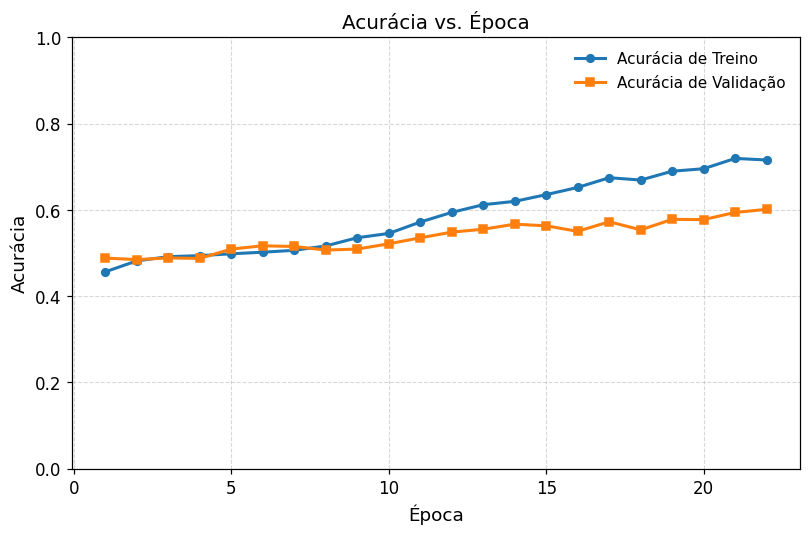

Figura salva em: acc_curve.png


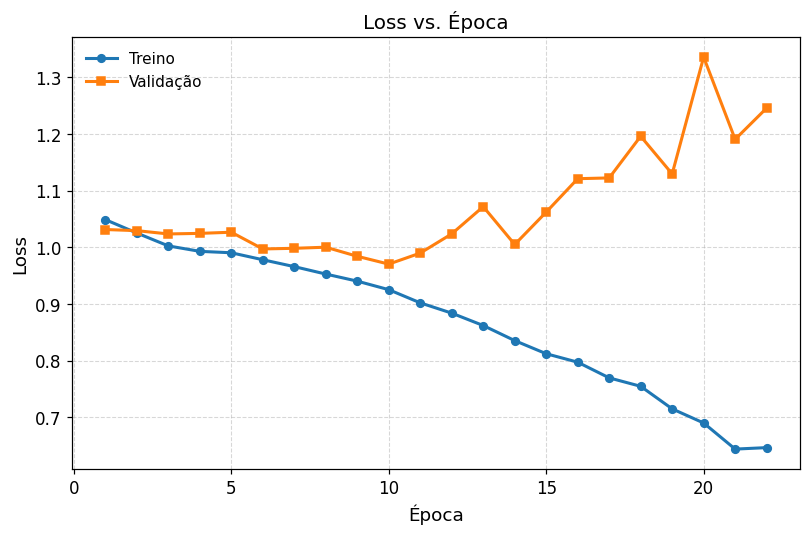

Figura salva em: loss_curve.png


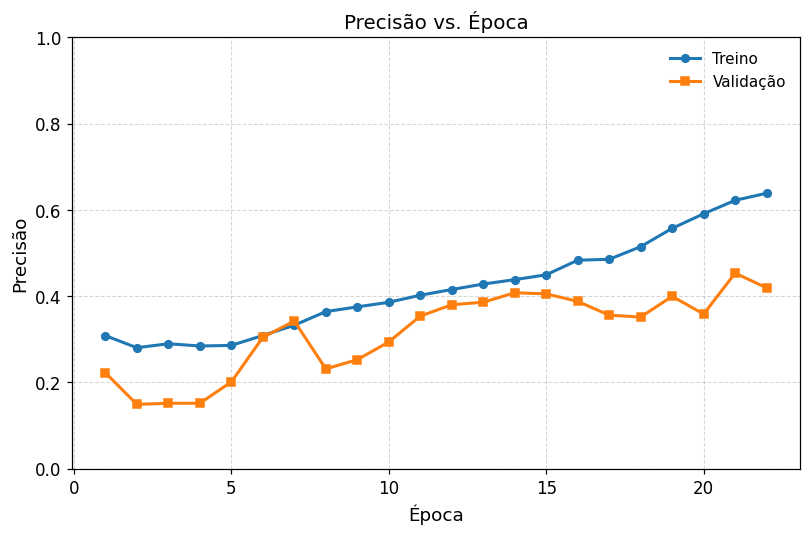

Figura salva em: precision_curve.png


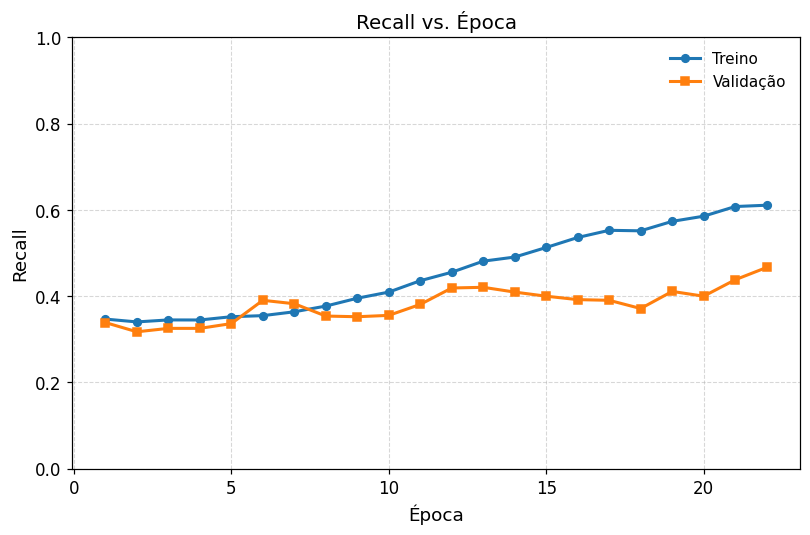

Figura salva em: recall_curve.png


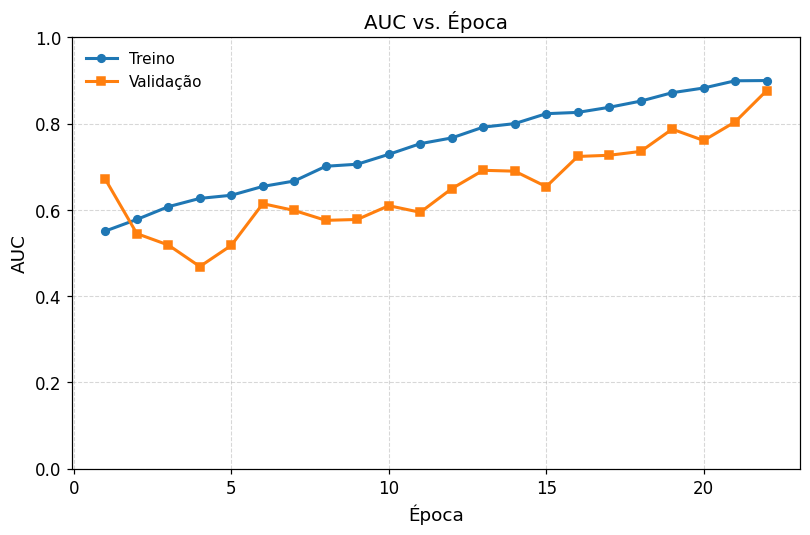

Figura salva em: auc_curve.png


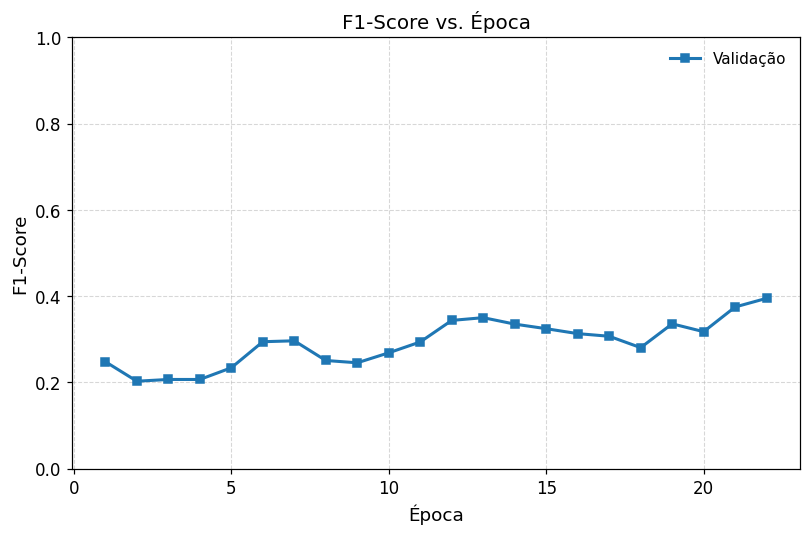

Figura salva em: f1_curve.png


In [ ]:

# Curvas de métricas (se existentes no escopo)
metrics_to_plot = [
    ("Acurácia", globals().get("acc_train_collect"), globals().get("acc_test_collect"), "acc_curve.png"),
    ("Loss", globals().get("loss_train_collect"), globals().get("loss_test_collect"), "loss_curve.png"),
    ("Precisão", globals().get("precision_train_collect"), globals().get("precision_test_collect"), "precision_curve.png"),
    ("Recall", globals().get("recall_train_collect"), globals().get("recall_test_collect"), "recall_curve.png"),
    ("AUC", globals().get("auc_train_collect"), globals().get("auc_test_collect"), "auc_curve.png"),
    ("F1-Score", globals().get("f1_train_collect"), globals().get("f1_test_collect"), "f1_curve.png"),
]
import numpy as np
import matplotlib.pyplot as plt

# estética global (opcional)
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
})

for title, train_vals, test_vals, fname in metrics_to_plot:
    if (train_vals is None or len(train_vals) == 0) and (test_vals is None or len(test_vals) == 0):
        print(f"[{title}] não encontrado — pulando.")
        continue

    fig = plt.figure(figsize=(7.5, 5), dpi=110)

    # eixo X
    if train_vals is not None and len(train_vals) > 0:
        x_tr = np.arange(1, len(train_vals) + 1)
        plt.plot(
            x_tr, train_vals,
            label="Acurácia de Treino" if "curáci" in title.lower() else "Treino",
            marker="o", markersize=5, linewidth=2,
        )
    if test_vals is not None and len(test_vals) > 0:
        x_te = np.arange(1, len(test_vals) + 1)
        plt.plot(
            x_te, test_vals,
            label="Acurácia de Validação" if "curáci" in title.lower() else "Validação",
            marker="s", markersize=5, linewidth=2,
        )

    # labels e título
    plt.xlabel("Época")
    plt.ylabel(title)
    # título no formato do exemplo: "<Métrica> vs. Época"
    plt.title(f"{title} vs. Época")

    # grade e limites
    plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.5)
    # para métricas entre 0 e 1, fixa o eixo Y; para Loss, deixa livre
    if any(k in title.lower() for k in ["acur", "precis", "recall", "auc", "f1"]):
        plt.ylim(0.0, 1.0)

    # legenda sem moldura
    plt.legend(frameon=False, loc="best")

    # acabamento e salvar/exibir
    plt.tight_layout()
    save_show(fig, fname)



Pesos carregados de best_model.pt


<Figure size 640x480 with 0 Axes>

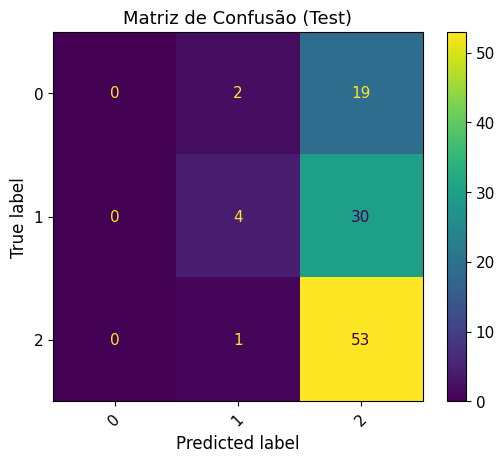

Figura salva em: confusion_matrix.png
Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        21
           1     0.5714    0.1176    0.1951        34
           2     0.5196    0.9815    0.6795        54

    accuracy                         0.5229       109
   macro avg     0.3637    0.3664    0.2915       109
weighted avg     0.4357    0.5229    0.3975       109

AUC (macro, OVR): 0.7013


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# Matriz de Confusão no conjunto de teste
ensure_best_weights(net_glob_client, net_glob_server)

# Seleciona o DataLoader de teste
_loader = None
if 'test_loader' in globals():
    _loader = test_loader
elif 'global_test_loader' in globals():
    _loader = global_test_loader
else:
    raise RuntimeError("Não encontrei test_loader. Execute as células de preparação de dados primeiro.")

y_true, y_pred, logits = predict_loader(_unwrap(net_glob_client), _unwrap(net_glob_server), _loader, device)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig = plt.figure()
disp.plot(values_format="d", xticks_rotation=45)
plt.title("Matriz de Confusão (Test)")
save_show(fig, "confusion_matrix.png")

print("Classification report:")
print(classification_report(y_true, y_pred, digits=4))

# AUC multiclass (opcional)
try:
    y_true_oh = np.eye(logits.shape[1])[y_true]
    auc_macro = roc_auc_score(y_true_oh, logits, multi_class='ovr')
    print(f"AUC (macro, OVR): {auc_macro:.4f}")
except Exception as e:
    print("AUC não pôde ser calculado:", e)



## Curvas ROC e Precision–Recall (por classe) e Taxa de Aprendizagem por Cliente
As células abaixo geram:
- **Curvas ROC** (um gráfico agregando as classes, OVR) e **Precision–Recall** por classe, utilizando `best_model.pt` se disponível.
- **Gráfico da taxa de aprendizagem** (learning rate) **por cliente** ao longo das rodadas.


Pesos carregados de best_model.pt


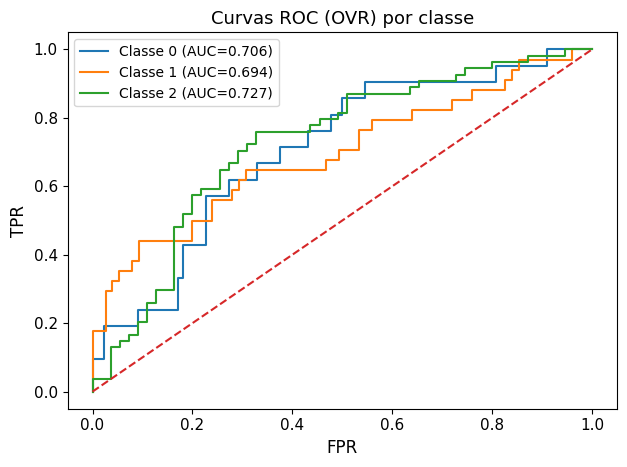

Figura salva em: roc_curves.png


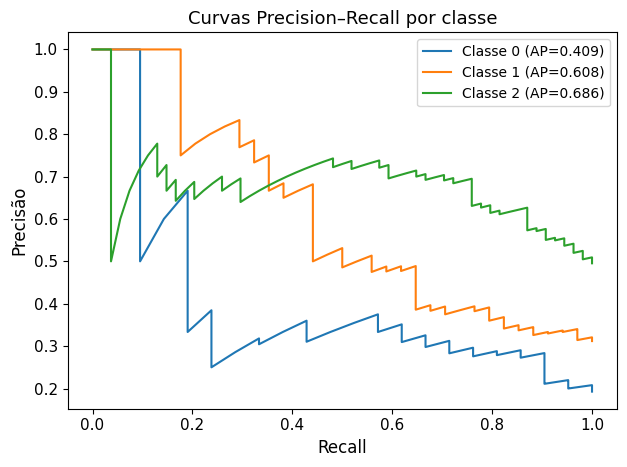

Figura salva em: pr_curves.png


In [ ]:

# Curvas ROC e Precision–Recall por classe
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Gera previsões no conjunto de teste
ensure_best_weights(net_glob_client, net_glob_server)

_loader = None
if 'test_loader' in globals():
    _loader = test_loader
elif 'global_test_loader' in globals():
    _loader = global_test_loader
else:
    raise RuntimeError("Não encontrei test_loader. Execute as células de preparação de dados primeiro.")

y_true, y_pred, logits = predict_loader(_unwrap(net_glob_client), _unwrap(net_glob_server), _loader, device)

# Softmax manual para obter probabilidades
logits_max = logits.max(axis=1, keepdims=True)
exp = np.exp(logits - logits_max)
probs = exp / exp.sum(axis=1, keepdims=True)

n_classes = probs.shape[1]

# ROC por classe (OVR)
fig = plt.figure()
for c in range(n_classes):
    y_bin = (y_true == c).astype(int)
    fpr, tpr, _ = roc_curve(y_bin, probs[:, c])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Classe {c} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC (OVR) por classe")
plt.legend()
save_show(fig, "roc_curves.png")

# Precision–Recall por classe
fig = plt.figure()
for c in range(n_classes):
    y_bin = (y_true == c).astype(int)
    prec, rec, _ = precision_recall_curve(y_bin, probs[:, c])
    ap = average_precision_score(y_bin, probs[:, c])
    plt.plot(rec, prec, label=f"Classe {c} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curvas Precision–Recall por classe")
plt.legend()
save_show(fig, "pr_curves.png")


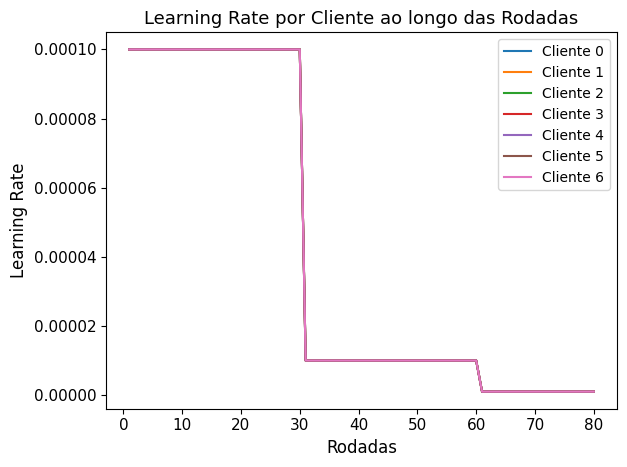

Figura salva em: client_lr_curves.png


In [ ]:

# Gráfico da taxa de aprendizagem por cliente ao longo das rodadas
import numpy as np, matplotlib.pyplot as plt, re, inspect

# Tenta obter parâmetros básicos
_global_rounds = globals().get("epochs", 0) or globals().get("num_epochs", 0) or 0
_num_users = globals().get("num_users", 1)
_base_lr = globals().get("lr", 1e-4)

# Defaults do StepLR usado no notebook original
step_size_default = 30
gamma_default = 0.1

# Tenta descobrir step_size/gamma do StepLR lendo a origem de LocalUpdate se existir
src_candidates = []
for name, obj in list(globals().items()):
    if inspect.isfunction(obj) or inspect.isclass(obj):
        try:
            s = inspect.getsource(obj)
            src_candidates.append(s)
        except Exception:
            pass
src_all = "\n".join(src_candidates)
m_step = re.search(r"StepLR\(optimizer_client,\s*step_size=(\d+),\s*gamma=([0-9.]+)\)", src_all)
if m_step:
    step_size = int(m_step.group(1))
    gamma = float(m_step.group(2))
else:
    step_size, gamma = step_size_default, gamma_default

# Caso histórico de LR real por cliente já exista, usamos.
# Ex: client_lr_history = {0:[...], 1:[...], ...}
lr_hist = globals().get("client_lr_history", None)

if lr_hist is None:
    # Reconstrução simples por rodada (assume StepLR aplicado ao longo das rodadas;
    # se o scheduler reinicia a cada rodada, o LR ficará constante em _base_lr).
    lr_hist = {}
    for cid in range(_num_users):
        lr_vals = []
        for r in range(_global_rounds or 1):
            lr_r = _base_lr * (gamma ** (r // step_size))
            lr_vals.append(lr_r)
        lr_hist[cid] = lr_vals

# Plot — um gráfico contendo as curvas de LR de todos os clientes
fig = plt.figure()
for cid, vals in lr_hist.items():
    if not isinstance(vals, (list, tuple, np.ndarray)):
        continue
    x = list(range(1, len(vals)+1))
    plt.plot(x, vals, label=f"Cliente {cid}")
plt.xlabel("Rodadas")
plt.ylabel("Learning Rate")
plt.title("Learning Rate por Cliente ao longo das Rodadas")
plt.legend()
save_show(fig, "client_lr_curves.png")
